## $\color{SkyBlue}{\text{Weather Analysis}}$
#### $\color{SkyBlue}{\text{Roman Lynch}}$


In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

$\rule{27cm}{0.4pt}$
### K-Means Algorithm

In [54]:
#--------------------------------------------------------------------------------#
def dist(x1, x2):
    return np.sqrt(np.sum(x1-x2)**2)
#--------------------------------------------------------------------------------#

In [55]:
#--------------------------------------------------------------------------------#
def kMeans(df, k=4, tol=0.005): 
    """
    Usage: input 
        df=data frame, 
        k=# of clusters
        tol=tolerance for L_2 convergance check on centroids
    """    
    #---------------------------------------#
    #-- Initialize --#
    clusters = np.zeros(len(df))
    centroids = df.sample(k).values
    mean_error = np.inf
    converged = False
    
    num_iterations = 0
    
    #---------------------------------------#
    #-- LOOP UNTIL CONVERGENCE --#
    while not(converged):
        
        #-- Cluster Assignment --#
        for index, data in enumerate(df.values):
            distances = [dist(data, centroid) for centroid in centroids]
            clusters[index] = np.argmin(distances)
        
        #-- Update Centroids --#
        updated_centroids = np.empty((k, df.shape[1]))
        for index in range(k):
            clust_data = df[clusters == index]
            centroid = clust_data.mean(axis=0)
            updated_centroids[index, :] = centroid
            
        #-- Calculate Meanerror --#
        errors = []
        for data, cluster in zip(df.values, clusters):
            centroid = updated_centroids[int(cluster)]
            errors.append(dist(data, centroid)**2)
        
        error_arr = np.array(errors)
        
        #-- Calculate Reconstruction Error --#
        rec_err = np.sum(error_arr)/len(df)
        
        #-- Check for Convergence --#
        if (abs(rec_err - mean_error) < tol):
            converged = True
#             print('Converged at iteration {} with a change of {}'.format(num_iterations, abs(rec_err - mean_error)))
        
        # Update Values
        centroids = updated_centroids
        mean_error = rec_err
        num_iterations = num_iterations + 1
        
    #---------------------------------------#
    return centroids, clusters, mean_error
#--------------------------------------------------------------------------------#

$\rule{27cm}{0.4pt}$ 
### Dataframe Composition

In [71]:
#--------------------------------------------------------------------------------#
# Creating the master data frame

## Read in CSV files
df_weather = pd.read_csv("data/city_temperature.csv")
df_rankings = pd.read_csv("data/rankings.csv")
df_teams = pd.read_csv("data/team.csv")

## Only take important columns
df_weather = df_weather[['City', 'Year', 'AvgTemperature']]
df_rankings = df_rankings[['Team', 'Rank', 'Year']]
df_teams = df_teams[['full_name', 'abbreviation', 'city']]

## Clean "*" from all teams in df_rankings
for i in range(len(df_rankings)):
    if (df_rankings["Team"].iloc[i].find('*')):
        df_rankings["Team"].iloc[i] = df_rankings["Team"].iloc[i].replace('*', '')

## Look onyl at cities in the nba
nba_cities = list(df_teams['city'].unique())

## Find wether data of nba_citites
df_weather = df_weather[df_weather['City'].isin(nba_cities)]

## Average the temperatures for each year and city such that there is only one instance of each city per year
df_weather = df_weather.groupby(['City', 'Year'])['AvgTemperature'].mean().reset_index()

## Convert AvgTemperature to fahrenheit
df_weather['AvgTemperature'] = df_weather['AvgTemperature']*(9/5) + 32

## Create the master dataframe by including wether, city, team, and rank
df_merged = pd.merge(df_rankings,df_teams, left_on="Team", right_on="full_name")
df_master = pd.merge(df_weather, df_merged, left_on=['City', 'Year'], right_on=['city', 'Year'])
#--------------------------------------------------------------------------------#

print(df_master.head(5))



      City  Year  AvgTemperature            Team  Rank       full_name  \
0  Atlanta  2018      146.852822   Atlanta Hawks    15   Atlanta Hawks   
1  Atlanta  2019      150.024274   Atlanta Hawks    12   Atlanta Hawks   
2  Atlanta  2020      132.911493   Atlanta Hawks    14   Atlanta Hawks   
3   Boston  2018      126.889589  Boston Celtics     2  Boston Celtics   
4   Boston  2019      127.637205  Boston Celtics     4  Boston Celtics   

  abbreviation     city  
0          ATL  Atlanta  
1          ATL  Atlanta  
2          ATL  Atlanta  
3          BOS   Boston  
4          BOS   Boston  


In [63]:
#--------------------------------------------------------------------------------#
# Break the data up by year
df_18 = df_master[df_master["Year"] == 2018]
df_19 = df_master[df_master["Year"] == 2019]
df_20 = df_master[df_master["Year"] == 2020]
df_21 = df_master[df_master["Year"] == 2021]
df_22 = df_master[df_master["Year"] == 2022]

print(df_18.shape[0])
print(df_19.shape[0])
print(df_20.shape[0])

# No wether data for 2021 and 2022
print(df_21.shape[0])
print(df_22.shape[0])
#--------------------------------------------------------------------------------#

21
21
21
0
0


$\rule{27cm}{0.4pt}$ 
### Perform K-means with k = 3

In [68]:
#--------------------------------------------------------------------------------#
## Use k-Means for clustering withk = 3
centroids_20, clusters_20, mean_error_20 = kMeans(df_20[["Rank", "AvgTemperature"]], k=3)
centroids_19, clusters_19, mean_error_19 = kMeans(df_19[["Rank", "AvgTemperature"]], k=3)
centroids_18, clusters_18, mean_error_18 = kMeans(df_18[["Rank", "AvgTemperature"]], k=3)
#--------------------------------------------------------------------------------#

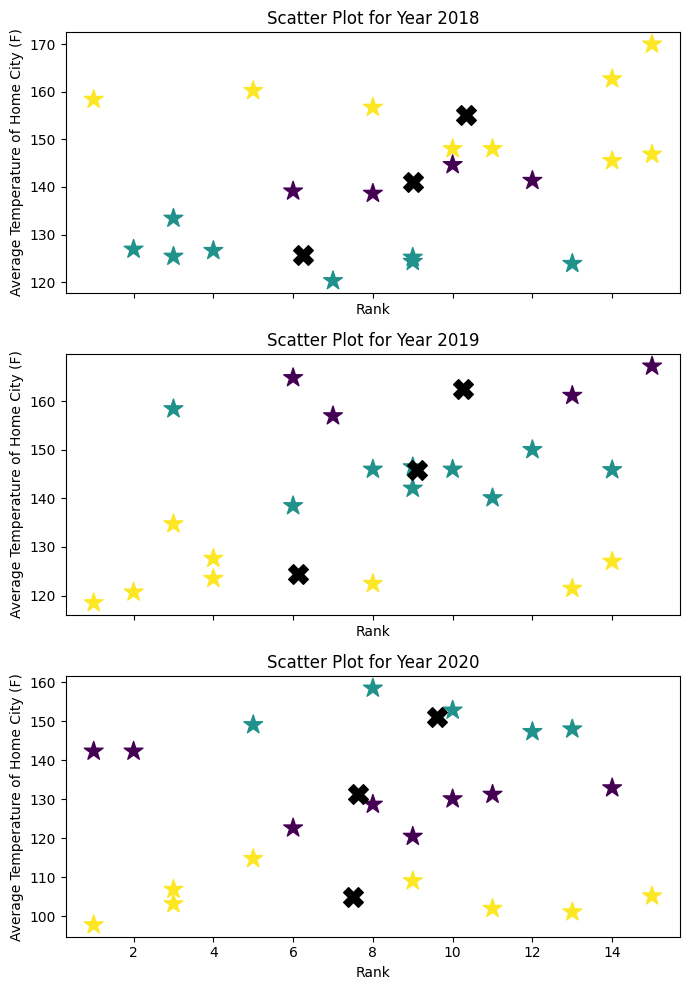

In [70]:
#--------------------------------------------------------------------------------#
# Organize output
dataframes = [df_18, df_19, df_20, df_21, df_22]
clusters = [clusters_18, clusters_19, clusters_20]
years = [2018, 2019, 2020, 2021, 2022, 2023]
centroids = [centroids_18,centroids_19,centroids_20]
#--------------------------------------------------------------------------------#

#--------------------------------------------------------------------------------#
# Plot the data

## Initialize Plot
fig, axes = plt.subplots(3, 1, figsize=(7, 10), sharex=True)

## Loop: Scatter Plot for each Year
for i, (year, dataframe, cluster) in enumerate(zip(years, dataframes, clusters)):
    ax = axes[i]
    ax.scatter(dataframe['Rank'], dataframe['AvgTemperature'], c=cluster, marker='*', s=200)
    ax.set_xlabel("Rank")
    ax.set_ylabel("Average Temperature of Home City (F)")
    ax.set_title("Scatter Plot for Year " + str(year))
    ## Plot centroids
    ax.scatter(centroids[i][:, 0], centroids[i][:, 1], marker='X', s=200, c='black')

plt.tight_layout()
plt.show()

plt.show()
#--------------------------------------------------------------------------------#